In [46]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

In [47]:
a = "purple is the best city in the forest"
b = "there is an art to getting your way and throwing bananas on to the street is not it"  # this is very similar to 'g'
c = "it is not often you find soggy bananas on the street"
d = "green should have smelled more tranquil but somehow it just tasted rotten"
e = "joyce enjoyed eating pancakes with ketchup"
f = "as the asteroid hurtled toward earth becky was upset her dentist appointment had been canceled"
g = "to get your way you must not bombard the road with yellow fruit"  # this is very similar to 'b'

In [48]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

In [49]:

tokens = tokenizer([a, b, c, d, e, f, g],
                          max_length=128,
                          truncation=True,
                          padding='max_length',
                          return_tensors='pt')

In [50]:

tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [51]:
tokens['input_ids'][0]

tensor([ 101, 6379, 2003, 1996, 2190, 2103, 1999, 1996, 3224,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [52]:
tokens['input_ids'][1]

tensor([  101,  2045,  2003,  2019,  2396,  2000,  2893,  2115,  2126,  1998,
         6886, 26191,  2006,  2000,  1996,  2395,  2003,  2025,  2009,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [53]:

outputs = model(**tokens)
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [54]:
embeddings = outputs.last_hidden_state
embeddings[0]

tensor([[-0.6239, -0.2058,  0.0411,  ...,  0.1490,  0.5681,  0.2381],
        [-0.3694, -0.1485,  0.3780,  ...,  0.4204,  0.5553,  0.1441],
        [-0.7221, -0.3813,  0.2031,  ...,  0.0761,  0.5162,  0.2813],
        ...,
        [-0.1894, -0.3711,  0.3034,  ...,  0.1536,  0.3265,  0.1376],
        [-0.2496, -0.5227,  0.2341,  ...,  0.3419,  0.3164,  0.0256],
        [-0.3311, -0.4430,  0.3492,  ...,  0.3655,  0.2910,  0.0728]],
       grad_fn=<SelectBackward>)

In [55]:
embeddings.shape # need to multiply by attention mask to get rid of padding

torch.Size([7, 128, 768])

In [56]:
tokens['attention_mask'].shape

torch.Size([7, 128])

In [57]:

mask = tokens['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
mask.shape

torch.Size([7, 128, 768])

In [58]:

mask[0]

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [59]:
masked_embeddings = embeddings * mask
masked_embeddings.shape # need to pool output across the 128 tokens while ignoring the 0 padded values, hence manual summing and counting operations need to be performed

torch.Size([7, 128, 768])

In [60]:

summed = torch.sum(masked_embeddings, 1)
summed.shape

torch.Size([7, 768])

In [61]:

counted = torch.clamp(mask.sum(1), min=1e-9)
counted.shape

torch.Size([7, 768])

In [62]:

mean_pooled = summed / counted
mean_pooled.shape

torch.Size([7, 768])

In [63]:

# convert to numpy array from torch tensor
mean_pooled = mean_pooled.detach().numpy()

# calculate similarities (will store in array)
scores = np.zeros((mean_pooled.shape[0], mean_pooled.shape[0]))
for i in range(mean_pooled.shape[0]):
    scores[i, :] = cosine_similarity(
        [mean_pooled[i]],
        mean_pooled
    )[0]

In [64]:
rounded_scores = np.around(scores, 2)
print(rounded_scores)

[[ 1.    0.19  0.28  0.3   0.27  0.1   0.22]
 [ 0.19  1.    0.72  0.51  0.12  0.19  0.66]
 [ 0.28  0.72  1.    0.49  0.24  0.17  0.56]
 [ 0.3   0.51  0.49  1.    0.27  0.38  0.52]
 [ 0.27  0.12  0.24  0.27  1.    0.23 -0.02]
 [ 0.1   0.19  0.17  0.38  0.23  1.    0.22]
 [ 0.22  0.66  0.56  0.52 -0.02  0.22  1.  ]]


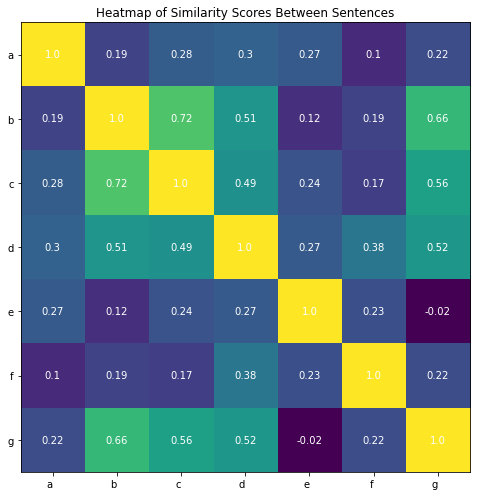

In [66]:
fig, ax = plt.subplots()
im = ax.imshow(rounded_scores)
fig.set_size_inches(7,7)

# We want to show all ticks...
ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(7))
# ... and label them with the respective list entries
ax.set_xticklabels(['a','b' , 'c', 'd', 'e', 'f', 'g'])
ax.set_yticklabels(['a','b' , 'c', 'd', 'e', 'f', 'g'])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(7):
    for j in range(7):
        text = ax.text(j, i, rounded_scores[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Heatmap of Similarity Scores Between Sentences")
fig.tight_layout()
plt.show()